# Ein Simulationsexperiment durchführen

Um den Effekt eines Modellparameters auf den Ablauf der Simulation bzw. auf einen *Outcome* zu untersuchen, führt man typischerweise Simulationsexperimente durch. Dabei lässt man ein Modell mehrmals mit verschiedenen Parameterwerten laufen, misst für jedes Modell einen interessierenden "Output" mit einer geeigneten Maßzahl, vergleicht die Ergebnisse zwischen den Modellen und schaut, ob die Variation des Parameters einen Unterschied für die Ergebnisse des Modells macht. Mit Pandas haben wir jetzt das richtige Werkzeug, um die Daten eines solchen Simulationsexperimentes sinnvoll zu speichern und für weitere Analysen handhabbar zu machen.

Im Folgenden demonstriere ich beispielhaft die Durchführung eines einfachen Simulationsexperimentes und einer sinnvollen Speicherung der dabei entstehenden Output-Daten anhand des allseits beliebten NaSch-Modells. Ziel des Experimentes ist es zu untersuchen, welchen Einfluss die Verkehrsdichte sowie die indivuduelle Auftretenswahrscheinlichkeit des Trödelns auf die durchschnittlich gefahrene Geschwindigkeit der Population hat.

Für die Durchführung eines Simulationsexperimentes sollte man sein Simulationsmodell in Form einer Funktion vorliegen haben, welche die im Experiment zu manipulierenden Parameter als Input aufnimmt und das interessierende Outcome als Output aus Funktion herausgibt. Wie ich gleich zeige, bietet es sich an, den Modell-Output als Dictionary aus der Funktion herauszugeben, damit am Ende des Simulationsexperimentes für jeden Modelldurchlauf ein eigenes Dictionary mit den relevanten Informationen/Daten vorliegt. Dann können alle Dictionaries zu einem Pandas-Dataframe vereint werden.

Unten ist die schon öfter verwendete Implementierung des NaSch-Modells innerhalb einer Funktion namens `nasch_model()` zu sehen, wobei jedoch auf den Teil für die grafische Darstellung verzichtet wurde. Die Funktion nimmt einige Input-Parameter auf, worunter auch die für uns im Experiment relevanten Parameter sind. Über die den Parameter `initial_distance` bestimmen wir die anfängliche Distanz zwischen den Agenten auf der Straße und somit die Verkehrsdichte. Je höher die `initial_distance`, desto geringer ist die Verkehrsdichte. Über den Parameter `dawdling_prob` können wir zudem die Trödelwahrscheinlichkeit einstellen. 

Die Parameter `intial_distance` und `dawdling_prob` sind quasi unsere *unabhängigen Variablen*, deren Einfluss auf die durchschnittlich gefahrene Geschwindigkeit wir untersuchen wollen. Die durchschnittlich gefahrene Geschwindigkeit ist somit unsere *abhängige Variable*. Diese abhängige Variable müssen wir natürlich irgendwie messen, weshalb ich den Code im Vergleich zu vorherigen Kapiteln etwas erweitern musste:


- Um die während der Simulation durchschnittlich gefahrene Geschwindigkeit zu messen, erstelle ich am Anfang der Funktion `nasch_model()` eine leere Liste namens `speed_data`. 


- In die Liste `speed_data` werden während der Simulation in jedem Zeitschritt und für jeden Agenten der aktuelle Geschwindigkeitswert angehängt. Den dafür notwendigen For-Loop findest du relativ weit unten im Code. 


- Nachdem alle Zeitschritte der Simulation durchgelaufen sind, wird die durchschnittliche Geschwindigkeit über alle Agenten und Zeitschritte berechnet und in der Variable `mean_speed` gespeichert. 


- Nun geschieht der wichtigste Schritt, welcher uns ein wohl strukturiertes Speichern der Daten innerhalb eines Dataframes erlaubt: Am Ende der Simulation wird ein Dictionary namens `output_dict` erstellt, in welchem alle relevanten Modelleigenschaften v.a. also die *Input*- und *Outputwerte* des Modells gespeichert werden. Dieses `output_dict` wird später eine Zeile eines Dataframes, welche die Daten mehrere Modelle beinhaltet, darstellen.

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt

def nasch_model(
    ticks=100, 
    max_speed=5,
    dawdling_prob=0.1,
    n_agents=100,
    initial_distance=6,
):
    
    # Datencontainer zur Sammlung der gefahrenen Geschwindigkeiten
    speed_data = []
    
    # Straßenlänge berechnen
    street_len = n_agents * initial_distance

    # Leere Liste, die gleich mit Agenten befüllt wird
    population = []

    # für jeden zu erstellenden Agenten
    for i in range(n_agents):

        # Agent als Dictionary erstellen
        agent = {
            "id": i,
            "position": i * initial_distance,
            "speed": max_speed,
            "space_ahead": initial_distance - 1,
        }

        # Agent an die Populationsliste hängen
        population.append(agent)


    # Population nochmal überarbeiten - jeweils vorausfahrende und nachfahrende Agenten einspeichern
    # für jeden Agenten in Population
    for agent in population:
        # den vorausfahrenden Agenten merken/als Eigenschaft einspeichern
        agent.update({"agent_ahead": population[(agent["id"]+1)%len(population)]})

        # den nachfahrenden Agenten merken/als Eigenschaft einspeichern
        agent.update({"agent_behind": population[(agent["id"]-1)%len(population)]})


    # für jeden Zeitschritt
    for tick in range(ticks):

        # für jeden Agenten (die vier Handlungsschritte umsetzen)
        for agent in population:
            # 1. Acceleration
            if agent["speed"] < max_speed:
                agent["speed"] += 1

            # 2. Slowing down
            if agent["speed"] > agent["space_ahead"]:
                agent["speed"] = agent["space_ahead"]

            # 3. Randomization
            if agent["speed"] > 0 and random.random() <= dawdling_prob:
                agent["speed"] -= 1

            # 4. Car motion
            agent["position"] = (agent["position"] + agent["speed"]) % street_len

        # für jeden Agenten (die Anzahl der freien Straßenabschnitte neu berechnen)
        for agent in population:
            # neue Anzahl der freien Zellen vor Agent berechnen und einspeichern
            agent["space_ahead"] -= agent["speed"]
            # neue Anzahl der freien Zellen vor dem NACHFAHRENDEM Agent berechnen und DIESEM einspeichern
            agent["agent_behind"]["space_ahead"] += agent["speed"]

        
################################################################################
# Geschwindigkeitsdaten sammeln, Durchschnitt berechnen und Output-Dict ausgeben
################################################################################
        
        # In jedem Zeitschritt von allen Agenten die aktuelle Geschwindigkeit sammeln
        for agent in population:
            speed_data.append(agent["speed"])
    
    # Durchschnittliche Geschwindigkeit pro Agent pro Zeitschritt berechnen
    mean_speed = sum(speed_data) / n_agents / ticks
    
    
    # Ausgabe-Dictionary mit Modellinformationen erstellen
    output_dict = {
        "mean_speed": mean_speed,
        "initial_distance": initial_distance,
        "dawdling_prob": dawdling_prob,
        "ticks": ticks,
        "n_agents": n_agents,
    }
    
    # Ausgabe-Dictionary ausgeben
    return output_dict

Lassen wir nun das Modell laufen, indem wir die obige Funktion ausführen, so bekommen wir ein Dictionary mit den relevanten Modellinformationen ausgegeben:

In [2]:
nasch_model(initial_distance=3)

{'mean_speed': 1.6869,
 'initial_distance': 3,
 'dawdling_prob': 0.1,
 'ticks': 100,
 'n_agents': 100}

In [3]:
nasch_model(initial_distance=1)

{'mean_speed': 0.0,
 'initial_distance': 1,
 'dawdling_prob': 0.1,
 'ticks': 100,
 'n_agents': 100}

Unsere Funktion ist nun soweit, dass sie uns für einen entsprechenden Parameter-Input das Simulationsmodell laufen lässen und uns anschließend einen kompakten Output mit allen relevanten Informationen zum vollzogenenen Modelldurchlauf in einem Dictionary zurückliefert. In einem Simulationsexperiment lassen führen wir die Funktion für verschiedene Parameter-Werte aus, speichern die jeweils zurückgegebenen Dictionaries mit den relevanten Informationen in einer Liste und können diese dann in einen Pandas-Dataframe überführen, um die Daten auszuwerten.

## Experiment mit einer unabhängigen Variable

Untersuchen wir zunächst allein den Effekt der Verkehrsdichte auf die durchschnittliche Geschwindigkeit. Die Verkehrsdichte wird im Modell über das Argugment `initial_distance`, welche die anfängliche Distanz zwischen den Agenten auf der Straße angibt, gesteuert. 

- In einer Liste `list_of_initial_distances` habe ich alle Werte, die im Experiment für `intial_distance` eingesetzt werden sollen, gespeichert. Natürlich hätte man hier auch z.B. die Funktion `range()` nutzen können, um eine solche Liste zu erstellen.


- Die anfänglich leere Liste `data` ist dafür da, die Output-Dictionaries aller Simulationsdurchläufe zu sammeln


- In einem For-Loop über die Liste `list_of_initial_distances` wird die Funktion nun nacheinander für alle Werte der Liste `list_of_initial_distances` aufgerufen, die Ergebnisse in der Variable `simulation_results` zwischengespeichert und schließlich an die Liste `data` angehängt.

In [4]:
# Liste der im Experiment für den Parameter "initial_distance" einzusetzende Werte
list_of_initial_distances = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 100]

# Liste für Sammlung der Output-Dictionaries der einzelnen Modelle
data = []

# für jeden Parameterwert aus list_of_initial_distances
for initial_distance in list_of_initial_distances:
    
    # Simulation laufen lassen
    simulation_results = nasch_model(initial_distance=initial_distance)
    
    # Simulationsergebnisse an Sammelliste anhängen
    data.append(simulation_results)

Als Ergebnis haben wir nun die Liste `data`, welche alle Informationen zu allen Modelldurchläufen enthält. Wie man unten sieht, ist die Liste `data` eine Liste mit Dictionaries:

In [5]:
data

[{'mean_speed': 0.0,
  'initial_distance': 1,
  'dawdling_prob': 0.1,
  'ticks': 100,
  'n_agents': 100},
 {'mean_speed': 0.8339,
  'initial_distance': 2,
  'dawdling_prob': 0.1,
  'ticks': 100,
  'n_agents': 100},
 {'mean_speed': 1.6796,
  'initial_distance': 3,
  'dawdling_prob': 0.1,
  'ticks': 100,
  'n_agents': 100},
 {'mean_speed': 2.5006,
  'initial_distance': 4,
  'dawdling_prob': 0.1,
  'ticks': 100,
  'n_agents': 100},
 {'mean_speed': 3.4216,
  'initial_distance': 5,
  'dawdling_prob': 0.1,
  'ticks': 100,
  'n_agents': 100},
 {'mean_speed': 4.0746,
  'initial_distance': 6,
  'dawdling_prob': 0.1,
  'ticks': 100,
  'n_agents': 100},
 {'mean_speed': 4.8,
  'initial_distance': 7,
  'dawdling_prob': 0.1,
  'ticks': 100,
  'n_agents': 100},
 {'mean_speed': 4.8506,
  'initial_distance': 8,
  'dawdling_prob': 0.1,
  'ticks': 100,
  'n_agents': 100},
 {'mean_speed': 4.8812,
  'initial_distance': 9,
  'dawdling_prob': 0.1,
  'ticks': 100,
  'n_agents': 100},
 {'mean_speed': 4.8924,
 

Wie wir eben gelernt haben, können wir Dataframes aus solchen Listen mit gleichartigen Dictionaries erstellen, was ich im Folgenden tue:

In [6]:
df = pd.DataFrame(data)

Das Ergebnis ist ein übersichtlicher, tabellenförmiger Datensatz mit den Daten unseres Simulationsexperimentes. Jede Zeile entspricht einem Dictionary der Liste `data` und repräsentiert somit die Ergebnisse/Informationen eines Simulationsdurchgang.

In [7]:
df

,mean_speed,initial_distance,dawdling_prob,ticks,n_agents
0,0.0000,1,0.1,100,100
1,0.8339,2,0.1,100,100
2,1.6796,3,0.1,100,100
3,2.5006,4,0.1,100,100
4,3.4216,5,0.1,100,100
5,4.0746,6,0.1,100,100
6,4.8000,7,0.1,100,100
7,4.8506,8,0.1,100,100
8,4.8812,9,0.1,100,100
9,4.8924,10,0.1,100,100


(An dieser Stelle könnte man nun bereits mittels `df.to_csv(DATEIPFAD)` den Datensatz exportieren und in einem beliebigen Statistik-Programm aufbereiten und auswerten.)

Um den Effekt der Verkehrsdichte auf die Durchschnittsgeschwindigkeit besser interpretieren zu können, ist sinnvoll die Verkehrsdichte als *Anteil der Straße, der durch Agenten belegt ist*, anzugeben. Dafür erstelle im im Folgenden eine neue Dataframe-Spalte `df["traffic_density"]`, welche ich als `1 / df["initial_distance"]` berechne.

In [8]:
df["traffic_density"] = 1 / df["initial_distance"]

In [9]:
df

,mean_speed,initial_distance,dawdling_prob,ticks,n_agents,traffic_density
0,0.0000,1,0.1,100,100,1.000000
1,0.8339,2,0.1,100,100,0.500000
2,1.6796,3,0.1,100,100,0.333333
3,2.5006,4,0.1,100,100,0.250000
4,3.4216,5,0.1,100,100,0.200000
5,4.0746,6,0.1,100,100,0.166667
6,4.8000,7,0.1,100,100,0.142857
7,4.8506,8,0.1,100,100,0.125000
8,4.8812,9,0.1,100,100,0.111111
9,4.8924,10,0.1,100,100,0.100000


Die Ergebnisse könnte man nun natürlich mithilfe von Matplotlib grafisch anzeigen. Dafür kann man die relevanten Spalten einzeln anwählen und z.B. in die Funktion `plt.plot()` eingeben, so wie ich es unten tue.

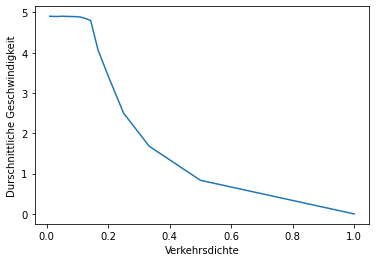

In [10]:
import matplotlib.pyplot as plt

plt.plot(df["traffic_density"], df["mean_speed"])
plt.xlabel("Verkehrsdichte")
plt.ylabel("Durschnittliche Geschwindigkeit")
plt.show()

Die Ergebnisse des Experimentes zeigen bisher, dass eine Erhöhung der Verkehrsdichte nach einem anfänglichen Plateu bei sehr niedriger Straßenauslastung zu einem sehr starken Absinken der durchschnittlich gefahrenen Geschwindigkeit führt. Es gibt somit einen *kritischen Punkt*, wo eine Erhöhung der Verkehrsdichte zu einem rapiden Ausbremsen des Verkehrs führt.

Mit Matplotlib wird das Anzeigen der Ergebnisse aber spätestens, wenn wir eine dritte Variable im Diagramm darstellen wollen, unnötig kompliziert, weshalb wir in Kürze einen kurzen Blick auf das Grafik-Paket **Seaborn** werfen werden

## Experiment mit zwei unabhängigen Variablen

Nun wollen wir in einem weiteren Experiment prüfen, welche Rolle das Ausmaß von unnötigem Abbremsen d.h. der Höhe der Trödelwahrscheinlichkeit für den Zusammenhang zwischen Verkehrsdichte und Durchschnittsgeschwindkeit spielt. Genaugenommen prüfen wir damit einen sogenannten Interaktionseffekt bzw. eine Moderation. 

Im Folgenden lasse ich die Funktion `nasch_model()` nicht nur mit unterschiedlichen Werten für das Argument `initial_distance` laufen, sondern zudem lasse ich mithilfe eines zweiten For-Loops ebenfalls die Werte für das Argument `dawdling_prob` (die Trödelwahrscheinlichkeit) variieren. Dadurch wird das obige Experiment für verschiedene Werte der Trödelwahrscheinlichkeit jeweils komplett wiederholt.

In [11]:
# Liste der im Experiment für den Parameter "dawdling_prob" einzusetzende Werte
list_of_dawdling_probs = [0, 0.2, 0.4]

# Liste der im Experiment für den Parameter "initial_distance" einzusetzende Werte
list_of_initial_distances = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 100]

# Liste für Sammlung der Output-Dictionaries der einzelnen Modelle
data = []

 # für jeden Parameterwert aus list_of_dawdling_probs
for dawdling_prob in list_of_dawdling_probs:
    
    # für jeden Parameterwert aus list_of_initial_distances
    for initial_distance in list_of_initial_distances:

        # Simulation laufen lassen; initiale Distanz & Trödelwahrscheinlichkeit einsetzen
        simulation_results = nasch_model(initial_distance=initial_distance, dawdling_prob=dawdling_prob)

        # Simulationsergebnisse an Sammelliste anhängen
        data.append(simulation_results)

Nun überführe ich die gesammelten Daten in einen Dataframe und berechne wieder die Verkehrsdichte als Anteilswert der Straßenbelegung:

In [12]:
# Liste von Dictionaries in Dataframe umwandeln
df = pd.DataFrame(data)

# Verkehrsdichte als Anteilswert berechnen
df["traffic_density"] = 1 / df["initial_distance"]

Schauen wir uns den Dataframe an. Dieser ist nun insgesamt drei mal so lang wie im vorherigen Experiment. Wie man nun sehen kann, variiert nun nicht nur die `inital_distance` sondern auch die `dawdling_prob`:

In [13]:
df

,mean_speed,initial_distance,dawdling_prob,ticks,n_agents,traffic_density
0,0.0000,1,0.0,100,100,1.000000
1,1.0000,2,0.0,100,100,0.500000
2,2.0000,3,0.0,100,100,0.333333
3,3.0000,4,0.0,100,100,0.250000
4,4.0000,5,0.0,100,100,0.200000
5,5.0000,6,0.0,100,100,0.166667
6,5.0000,7,0.0,100,100,0.142857
7,5.0000,8,0.0,100,100,0.125000
8,5.0000,9,0.0,100,100,0.111111
9,5.0000,10,0.0,100,100,0.100000


Wie man nun das Ergebnis eines solchen Experimentes in einem Diagramm mit 3 Variablen darstellen kann, schauen wir uns im Folgenden Exkurs zum Paket Seaborn an.

## Exkurs: Ergebnisse mit Seaborn darstellen

Um den gemeinsamen Effekt der Verkehrsdichte und der Trödelwahscheinlichkeit auf die Durchschnittsgeschwindigkeit darzustellen, bietet sich u.a. ein Linien-Diagramm an, in welchem der Zusammenhang zwischen Verkehrsdichte und Durchschnittsgeschwindigkeit getrennt nach jeweilige Trödelwahscheinlichkeit abgetragen ist. Für solche Diagramme ist Matplotlib allerdings unnötig kompliziert, weshalb ich empfehle mal einen Blick auf das Paket [Seaborn](https://seaborn.pydata.org/) zu werfen. Mit Seaborn kann man Daten relativ unkompliziert gruppiert nach einer dritten Variable anzeigen lassen. Zudem ist Seaborn auf die Verwendung von Pandas-Dataframes zugeschnitten.


- Nachdem Seaborn über den Anaconda-Navigator installiert wurde, kann dieses als `import seaborn as sns` importiert werden. 


- Mit `sns.set_theme()` stelle ich das Standard-Farbschema ein. 


- Für Liniendiagramme bietet Seaborn die Funktion `lineplot()`. Diese erwartet, dass man unter dem Argument `data` einen Dataframe angibt, in dem die zu plottenden Daten stecken. Mit den Argumenten `x` und `y` gibt man jeweils die Namen der Dataframe-Spalten an, welche auf X- und Y-Achse geplottet werden sollen, an. Mit dem Argument `hue` kann man die Daten nun noch nach einer dritten Variable gruppieren. Unten gebe ich für `hue` den Spalte `"dawdling_prob"` an, sodass die Simulationsergebnisse jeweils getrennt nach der eingestellten Trödelwahrscheinlichkeit angezeigt werden.

<AxesSubplot:xlabel='traffic_density', ylabel='mean_speed'>

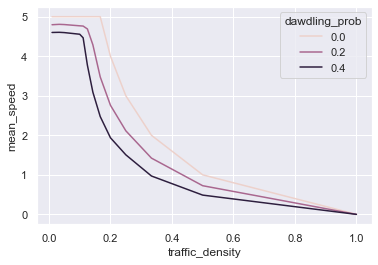

In [14]:
# Seaborn importieren
import seaborn as sns

# Standard-Farbschema einstellen
sns.set_theme()

# Seaborn-Liniendiagramm
sns.lineplot(
    data=df, # Dataframe, in welchem sich die Variablen/Spalten befinden
    x="traffic_density", # X-Variable
    y="mean_speed", # Y-Variable
    hue="dawdling_prob", # Gruppierungsvariable / Z-Variable
)

Die Ergebnisse zeigen, dass durch das Vorhandensein von "Trödeln" u.a. der Kipp-Punkt, ab welchem eine Erhöhung der Verkehrsdichte die gefahrene Durchschnittsgeschwindigkeit deutlich absenkt, bereits bei niedrigeren Verkehrsdichten auftritt.

## Mehrere Replikationen einer Parameterkombination

Spielt in einem Simulationsmodell der Zufall eine große Rolle, dann ist es gängige Praxis, für jede Kombination an Parametern mehrere Wiederholungen des Modells zu rechnen und dann den Mittelwert über alle Wiederholungen pro Parameterkombination zu berechnen, um eventuellen Zufallsschwankungen auf der interessierenden abhängigen Variable entgegenzuwirken.

Ein Weg, um mehrere Replikationen für eine Parameterkombination laufen zu lassen, kann sein, einfach einen weiteren For-Loop zu verwenden, um für jede Parameterkombination eine bestimmte Anzahl an Wiederholungen der Modelldurchläufe laufen zu lassen. Unten füge ich daher in den bisherigen Code einen weiteren For-Loop `for replication in range(10):` ein, welcher bewirkt, dass die Funktion `nasch_model()` 10 mal für jede Kombination von `dawdling_prob` und `initial_distance` ausgeführt wird und die Daten gespeichert werden. Der Output-Datensatz wird dadurch demendsprechend nochmal um den Faktor 10 länger.

In [15]:
# Liste der im Experiment für den Parameter "dawdling_prob" einzusetzende Werte
list_of_dawdling_probs = [0, 0.2, 0.4]

# Liste der im Experiment für den Parameter "initial_distance" einzusetzende Werte
list_of_initial_distances = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 100]

# Liste für Sammlung der Output-Dictionaries der einzelnen Modelle
data = []

 # für jeden Parameterwert aus list_of_dawdling_probs
for dawdling_prob in list_of_dawdling_probs:
    
    # für jeden Parameterwert aus list_of_initial_distances
    for initial_distance in list_of_initial_distances:
        
        # 10 Wiederholungen 
        for replication in range(10):

            # Simulation laufen lassen; initiale Distanz & Trödelwahrscheinlichkeit einsetzen
            simulation_results = nasch_model(initial_distance=initial_distance, dawdling_prob=dawdling_prob)

            # Simulationsergebnisse an Sammelliste anhängen
            data.append(simulation_results)


    
# Liste von Dictionaries in Dataframe umwandeln
df = pd.DataFrame(data)

# Verkehrsdichte als Anteilswert berechnen
df["traffic_density"] = 1 / df["initial_distance"]

Das praktische an Seaborn ist nun, dass es ganz von alleine merkt, dass für jede Kombination der Parameter in unserem Datensatz mehrere Zeilen vorliegen, rechnet selbständig den Mittelwert für jede Parameterkombination und zeigt diesen dann im Liniendiagramm an.

<AxesSubplot:xlabel='traffic_density', ylabel='mean_speed'>

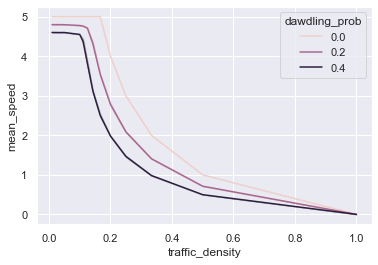

In [16]:
# Seaborn-Liniendiagramm
sns.lineplot(
    data=df, # Dataframe, in welchem sich die Variablen/Spalten befinden
    x="traffic_density", # X-Variable
    y="mean_speed", # Y-Variable
    hue="dawdling_prob", # Gruppierungsvariable / Z-Variable
)

Eigentlich zeigt Seaborn auch automatisch ein Art Konfidenzintervall um die berechneten Mitttelwerte an. Im Falle des NaSch-Modells scheint die Streuung zwischen den einzelnen Simulationen mit gleichen Parametern allerdings so gering zu sein, dass man dieses im obigen Diagramm nicht sieht.